In [1]:
import pickle

In [2]:
test_data = pickle.load(open('point_transformer_predictions_4.pkl', 'rb'))

In [3]:
test_data.keys()

dict_keys(['inputs', 'ground_truth', 'predictions', 'losses', 'avg_loss'])

In [4]:
import sqlite3
import numpy as np
from tqdm import tqdm

input_db_path = 'point_clouds_pressure_stratified.db'

with sqlite3.connect(input_db_path) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT data FROM point_clouds")
        
        xyz_min = np.array([float('inf')] * 3)
        xyz_max = np.array([float('-inf')] * 3)
        pressure_min = float('inf')
        pressure_max = float('-inf')
        
        for row in tqdm(cursor.fetchall()):
            points = np.frombuffer(row[0], dtype=np.float32).reshape(8192, 7)
            xyz_min = np.minimum(xyz_min, points[:, :3].min(axis=0))
            xyz_max = np.maximum(xyz_max, points[:, :3].max(axis=0))
            pressure_min = min(pressure_min, points[:, 3].min())
            pressure_max = max(pressure_max, points[:, 3].max())
        
        xyz_range = xyz_max - xyz_min
        pressure_range = pressure_max - pressure_min

print(f"XYZ min: {xyz_min}")
print(f"XYZ max: {xyz_max}")
print(f"Pressure min: {pressure_min}")
print(f"Pressure max: {pressure_max}")
print(f"XYZ range: {xyz_range}")
print(f"Pressure range: {pressure_range}")

100%|██████████| 8129/8129 [00:01<00:00, 5306.98it/s]

XYZ min: [-1.15140998 -1.19430006  0.        ]
XYZ max: [4.20227003 1.19430006 1.76177001]
Pressure min: -27552.19921875
Pressure max: 6858.10986328125
XYZ range: [5.35368001 2.38860011 1.76177001]
Pressure range: 34410.30859375


In [5]:
inputs1 = test_data['inputs'][0].shape

In [6]:
gt1 = test_data['ground_truth'][0]

In [7]:
prd1 = test_data['predictions'][0]

Inputs shape: (4, 8192, 3)
Ground truth shape: (4, 8192, 1)
Predictions shape: (4, 8192, 1)


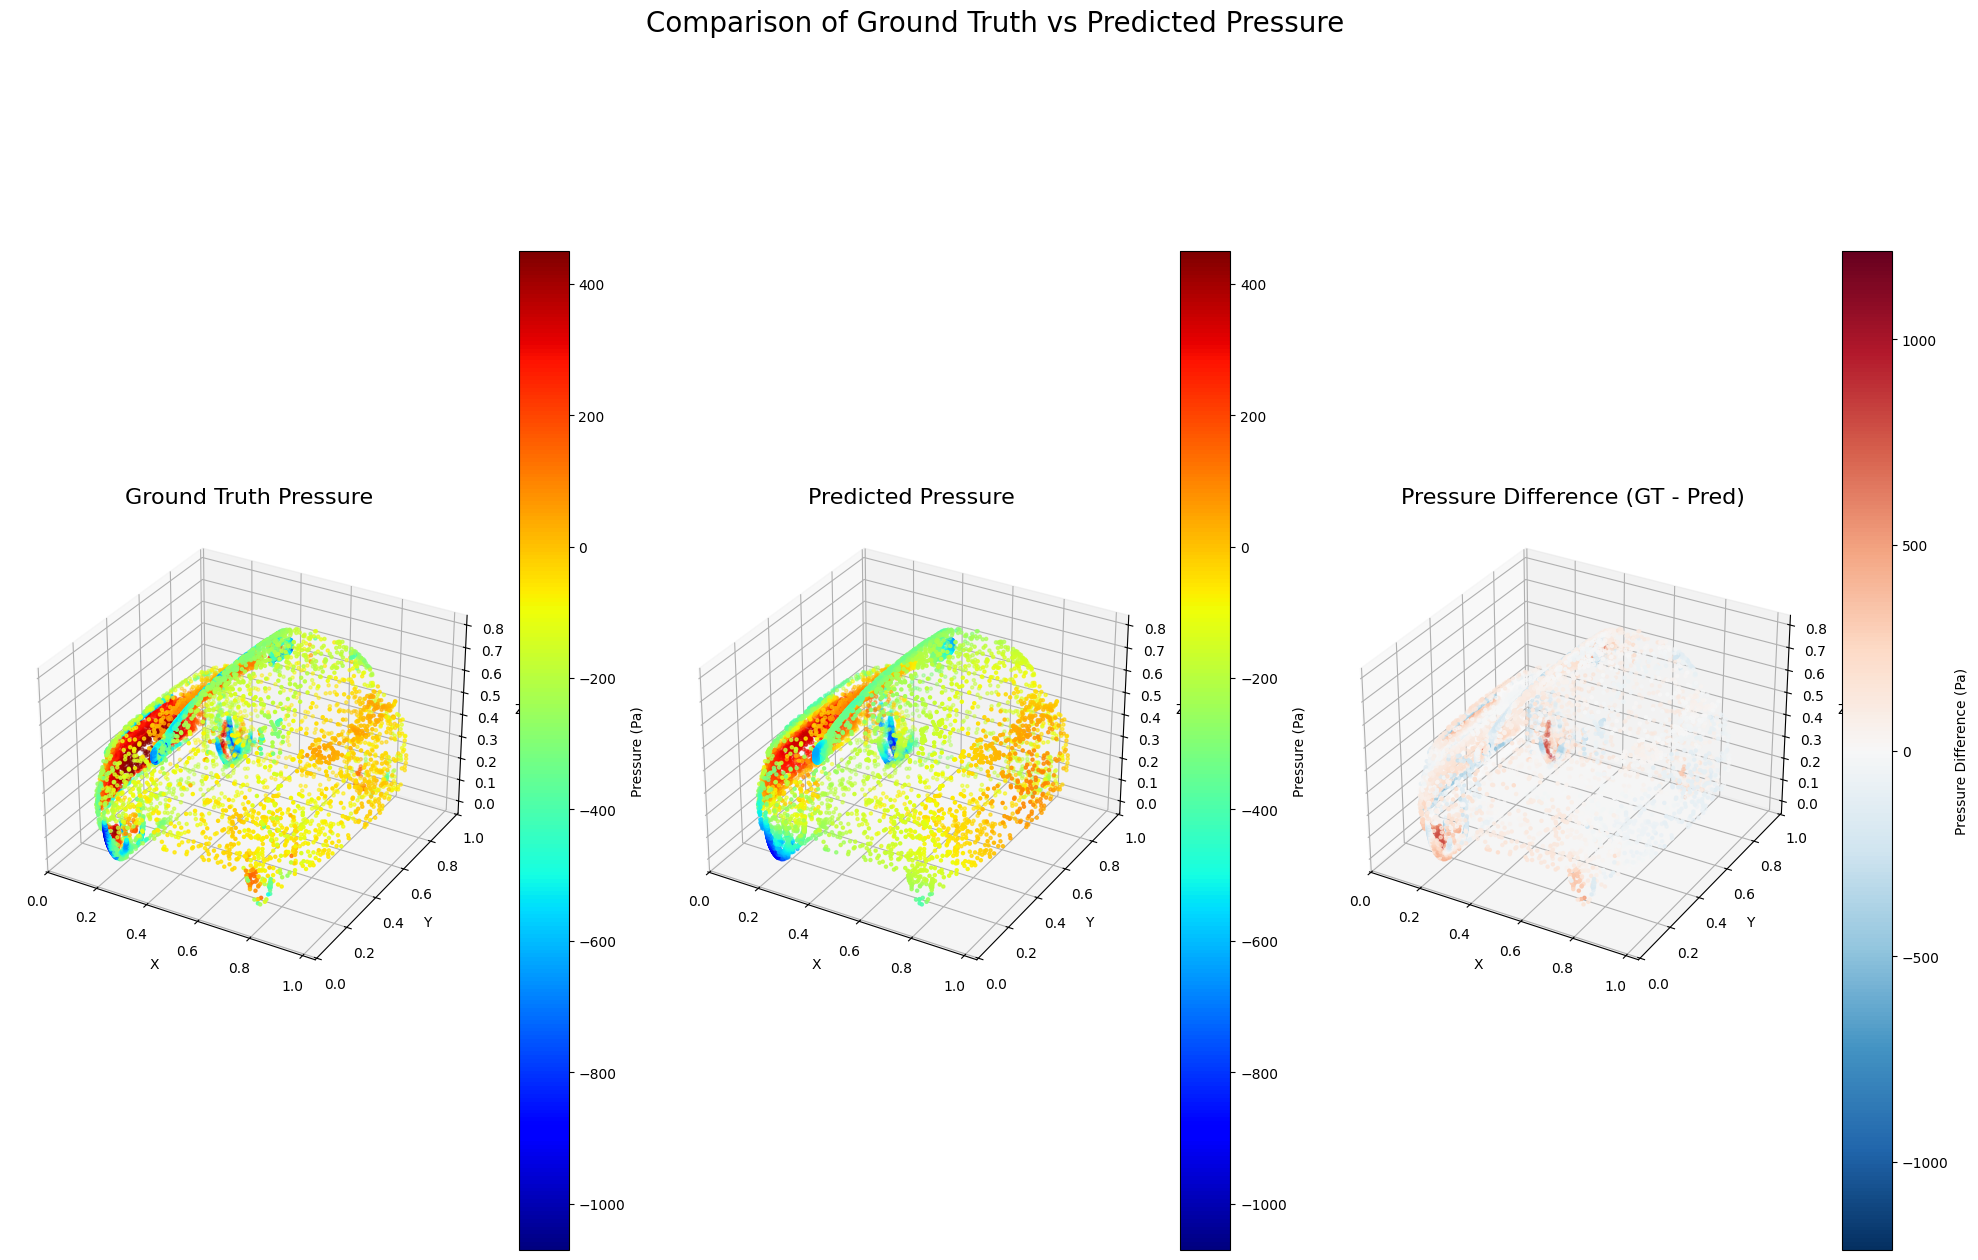

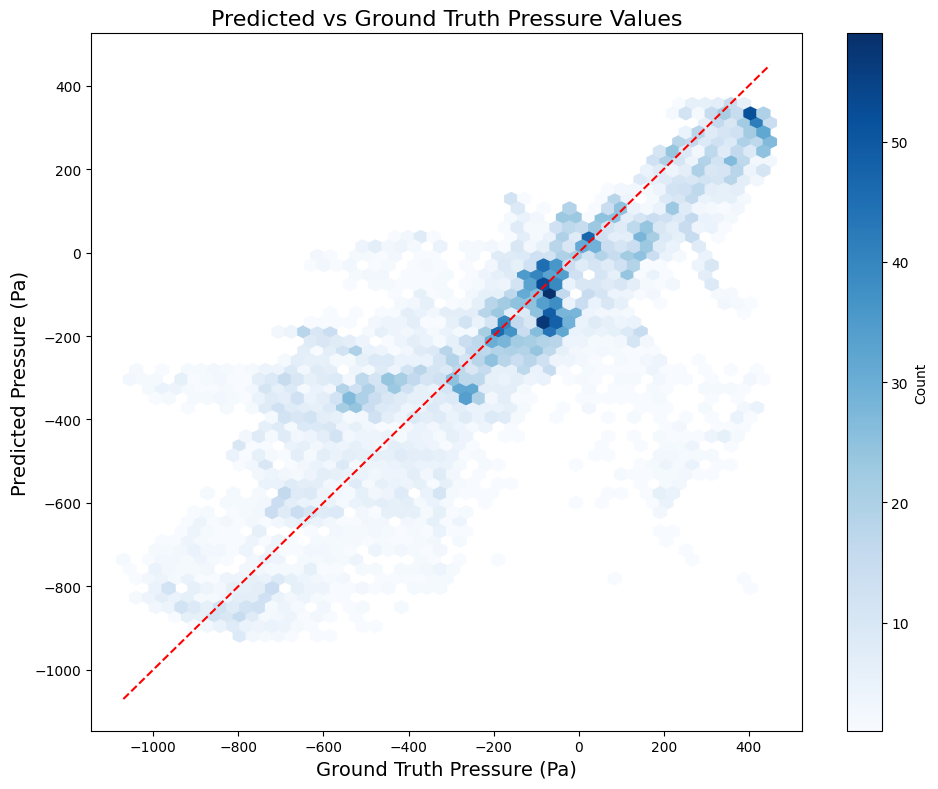

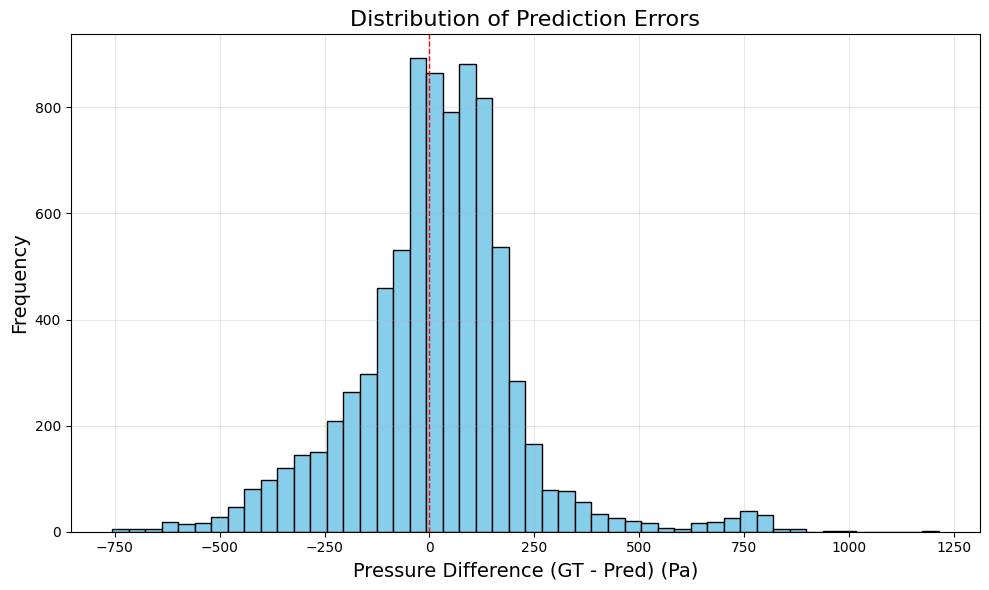

Mean Squared Error: 40509.58594 Pa²
Mean Absolute Error: 142.89340 Pa
Relative Mean Absolute Error: 44.37376%


In [10]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Check shapes to confirm our understanding
print(f"Inputs shape: {test_data['inputs'][0].shape}")
print(f"Ground truth shape: {test_data['ground_truth'][0].shape}")
print(f"Predictions shape: {test_data['predictions'][0].shape}")

# Define normalization parameters
pressure_min = -27552.19921875
pressure_max = 6858.10986328125

# Function to denormalize pressure values
def denormalize_pressure(normalized_pressure):
    return normalized_pressure * (pressure_max - pressure_min) + pressure_min
    # return normalized_pressure

# Create a figure with subplots for comparison
fig = plt.figure(figsize=(20, 15))

# We'll visualize the first sample in the batch (index 0)
batch_idx = 1
sample_idx = 0

# Get the point cloud coordinates and pressure values for the first sample
points = test_data['inputs'][batch_idx][sample_idx]  # Shape: (4096, 3)
gt_pressure_norm = test_data['ground_truth'][batch_idx][sample_idx]  # Shape: (4096, 1)
pred_pressure_norm = test_data['predictions'][batch_idx][sample_idx]  # Shape: (4096, 1)

# Denormalize the pressure values
gt_pressure = denormalize_pressure(gt_pressure_norm)
pred_pressure = denormalize_pressure(pred_pressure_norm)

# Create 3D scatter plots for ground truth and prediction
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(points[:, 0], points[:, 1], points[:, 2], 
                      c=gt_pressure.flatten(), cmap='jet', s=5)
ax1.set_title('Ground Truth Pressure', fontsize=16)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
fig.colorbar(scatter1, ax=ax1, shrink=0.7, label='Pressure (Pa)')

ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(points[:, 0], points[:, 1], points[:, 2], 
                      c=pred_pressure.flatten(), cmap='jet', s=5)
ax2.set_title('Predicted Pressure', fontsize=16)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
fig.colorbar(scatter2, ax=ax2, shrink=0.7, label='Pressure (Pa)')

# Add a third subplot for the difference (error) visualization
ax3 = fig.add_subplot(133, projection='3d')
# Calculate the difference between ground truth and prediction
pressure_diff = gt_pressure - pred_pressure
# Use a diverging colormap to highlight positive and negative differences
scatter3 = ax3.scatter(points[:, 0], points[:, 1], points[:, 2], 
                      c=pressure_diff.flatten(), cmap='RdBu_r', s=5)
ax3.set_title('Pressure Difference (GT - Pred)', fontsize=16)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
fig.colorbar(scatter3, ax=ax3, shrink=0.7, label='Pressure Difference (Pa)')

# Use the same color scale for both ground truth and prediction plots for fair comparison
vmin = min(gt_pressure.min(), pred_pressure.min())
vmax = max(gt_pressure.max(), pred_pressure.max())
scatter1.set_clim(vmin, vmax)
scatter2.set_clim(vmin, vmax)

# Set symmetric color scale for difference plot to highlight errors
diff_abs_max = max(abs(pressure_diff.min()), abs(pressure_diff.max()))
scatter3.set_clim(-diff_abs_max, diff_abs_max)

plt.suptitle('Comparison of Ground Truth vs Predicted Pressure', fontsize=20)
plt.tight_layout()
plt.show()

# 2D histogram of predicted vs ground truth values (denormalized)
plt.figure(figsize=(10, 8))
plt.hexbin(gt_pressure.flatten(), pred_pressure.flatten(), 
           gridsize=50, cmap='Blues', mincnt=1)
plt.plot([gt_pressure.min(), gt_pressure.max()], 
         [gt_pressure.min(), gt_pressure.max()], 'r--')
plt.xlabel('Ground Truth Pressure (Pa)', fontsize=14)
plt.ylabel('Predicted Pressure (Pa)', fontsize=14)
plt.title('Predicted vs Ground Truth Pressure Values', fontsize=16)
plt.colorbar(label='Count')
plt.tight_layout()
plt.show()

# Histogram of the differences to better understand error distribution
plt.figure(figsize=(10, 6))
plt.hist(pressure_diff.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Pressure Difference (GT - Pred) (Pa)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and print some error metrics on the denormalized values
mse = np.mean((gt_pressure - pred_pressure)**2)
mae = np.mean(np.abs(gt_pressure - pred_pressure))
print(f"Mean Squared Error: {mse:.5f} Pa²")
print(f"Mean Absolute Error: {mae:.5f} Pa")

# Also calculate relative errors
mean_abs_gt = np.mean(np.abs(gt_pressure))
relative_mae = mae / mean_abs_gt * 100
print(f"Relative Mean Absolute Error: {relative_mae:.5f}%")

In [9]:
import numpy as np

# Calculate and print error metrics for a single sample
mse = np.mean((gt_pressure - pred_pressure)**2)
mae = np.mean(np.abs(gt_pressure - pred_pressure))
print(f"Mean Squared Error (single sample): {mse:.6f}")
print(f"Mean Absolute Error (single sample): {mae:.6f}")

# Calculate MSE and MAE over the entire dataset
all_gt = test_data['ground_truth']
all_pred = test_data['predictions']

# Initialize variables to accumulate errors
total_mse = 0
total_mae = 0
total_samples = 0

# Loop through all batches and samples
for batch_idx in range(len(all_gt)):
    batch_gt = all_gt[batch_idx]
    batch_pred = all_pred[batch_idx]
    
    # Get number of samples in this batch
    num_samples = batch_gt.shape[0]
    
    # Calculate errors for each sample in the batch and accumulate
    for sample_idx in range(num_samples):
        sample_gt = batch_gt[sample_idx]
        sample_pred = batch_pred[sample_idx]
        
        # Calculate errors
        sample_mse = np.mean((sample_gt - sample_pred)**2)
        sample_mae = np.mean(np.abs(sample_gt - sample_pred))
        
        # Accumulate weighted by number of points
        total_mse += sample_mse
        total_mae += sample_mae
        total_samples += 1

# Calculate average errors across all samples
avg_mse = total_mse / total_samples
avg_mae = total_mae / total_samples

print("\nError metrics across entire dataset:")
print(f"Mean Squared Error: {avg_mse:.6f}")
print(f"Mean Absolute Error: {avg_mae:.6f}")

Mean Squared Error (single sample): 0.000034
Mean Absolute Error (single sample): 0.004153

Error metrics across entire dataset:
Mean Squared Error: 0.000038
Mean Absolute Error: 0.004037
